In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from configs import *

plt.style.use('seaborn-v0_8')

In [2]:
df = pd.read_csv(f'{DATA_DIR}/filtered_purchases.csv')

unique_users = sorted(df['user_id'].unique())
unique_products = sorted(df['product_id'].unique())

print(f"{len(df)} Orders")
print(f"{len(unique_users)} Users, {len(unique_products)} Products")

4279036 Orders
37496 Users, 11181 Products


In [3]:
# Map product ids to product names
product_df = df[['product_id', 'product_name']].drop_duplicates()
pid_name_map = dict(zip(product_df['product_id'], product_df['product_name']))

In [4]:
# Create matrix for collaborative filtering, with 1 if user ordered the item, 0 if not
df['purchased'] = 1.0
order_matrix_df = pd.pivot_table(df, index='user_id', columns='product_id', values='purchased', fill_value=0.0)
product_ids = order_matrix_df.columns.tolist()
order_matrix_df_vals = order_matrix_df.values
order_matrix_df

product_id,1,3,4,10,23,25,28,32,34,35,...,49638,49640,49644,49647,49655,49659,49667,49678,49680,49683
user_id,,,,,,,,,,,,,,,,,,,,,
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
206193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
# Compute matrix of cosine similarity scores
col_norms = np.linalg.norm(order_matrix_df_vals, axis=0, keepdims=True)
# Avoid division by 0
col_norms[col_norms == 0] = 1.0
X_norm = order_matrix_df_vals / col_norms

# dot prod of all column combos
similarity_matrix = X_norm.T @ X_norm

In [6]:
# MinMax Scaling of each Score
np.fill_diagonal(similarity_matrix, np.nan)

sim_df = pd.DataFrame(similarity_matrix, 
                      index=product_ids, 
                      columns=product_ids)

sim_scores_scaled = sim_df.apply(
    lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x)), 
    axis=0
)

sim_scores_scaled

,1,3,4,10,23,25,28,32,34,35,...,49638,49640,49644,49647,49655,49659,49667,49678,49680,49683
1,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013813,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010578
3,0.000000,NaN,0.000000,0.056810,0.000000,0.057847,0.000000,0.000000,0.040799,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023434
4,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.096825,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.170533,0.000000,0.000000,0.000000,0.000000,0.000000,0.108055,0.029930
10,0.000000,0.071665,0.000000,NaN,0.244581,0.076394,0.000000,0.000000,0.244908,0.000000,...,0.000000,0.159460,0.048090,0.000000,0.218577,0.057295,0.054777,0.000000,0.182828,0.136917
23,0.000000,0.000000,0.000000,0.069849,NaN,0.020321,0.039947,0.057365,0.128990,0.044385,...,0.000000,0.046659,0.070357,0.078734,0.106594,0.335298,0.000000,0.000000,0.133740,0.122108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49659,0.000000,0.000000,0.000000,0.016035,0.328585,0.016328,0.000000,0.000000,0.069095,0.071327,...,0.000000,0.000000,0.000000,0.000000,0.085648,NaN,0.032196,0.000000,0.000000,0.063939
49667,0.000000,0.000000,0.000000,0.037946,0.000000,0.000000,0.037978,0.163613,0.136258,0.000000,...,0.000000,0.133076,0.066889,0.074853,0.000000,0.079693,NaN,0.000000,0.127148,0.090002
49678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077152,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.135884,0.000000,0.000000,0.000000,0.000000,NaN,0.086100,0.042397
49680,0.000000,0.000000,0.032236,0.055046,0.140996,0.046709,0.000000,0.000000,0.210836,0.000000,...,0.000000,0.042899,0.258748,0.000000,0.049002,0.000000,0.055261,0.082235,NaN,0.123621


In [7]:
sim_scores_scaled_array = sim_scores_scaled[product_ids].fillna(0.0).values

# Because the data is binary, weighted avg'ing does not make sense, so uses this as prediction
predictions = order_matrix_df_vals @ sim_scores_scaled_array

# Mask out already-ordered items, so our scores only consider new interactions, not known ones
predictions[order_matrix_df_vals == 1.0] = 0.0

item_cf_scores = predictions.mean(axis=0)

In [8]:
# Get z scores for cleaner & more interpretable score values
mean_score = item_cf_scores.mean()
std_score = item_cf_scores.std()

item_z_scores = (item_cf_scores - mean_score) / std_score

In [9]:
# Get top K items with highest z scores
K = 20
top_k = np.argsort(item_z_scores)[::-1][:K]
most_needed = [(product_ids[idx], item_z_scores[idx])for idx in top_k]

In [10]:
# Save top_k to CSV

results = []
for idx, (product_id, score) in enumerate(most_needed):
    rank = idx+1
    product_name = pid_name_map[product_id]
    results.append({
        'rank': rank,
        'product_id': product_id,
        'product_name': product_name,
        'score': score
    })

results_df = pd.DataFrame(results)

output_file = f"{DATA_DIR}/top_k_recs.csv"
results_df.to_csv(output_file, index=False)
results_df

,rank,product_id,product_name,score
0,1,10872,Cranberries,2.497365
1,2,13409,Dubliner Wedge Pre Cut Cheese,2.438136
2,3,25886,Wild Blend Rice,2.426323
3,4,22169,Pineapple Slices,2.424307
4,5,39886,Gin Gins Original Chewy Ginger Candy,2.381884
5,6,29694,Organic Coconut Oil,2.378722
6,7,6135,Cream Of Tartar,2.375401
7,8,37197,Elderflower & Rose Lemonade,2.372509
8,9,33706,Pomegranate Juice,2.370991
9,10,10859,Lemon Curd,2.353684


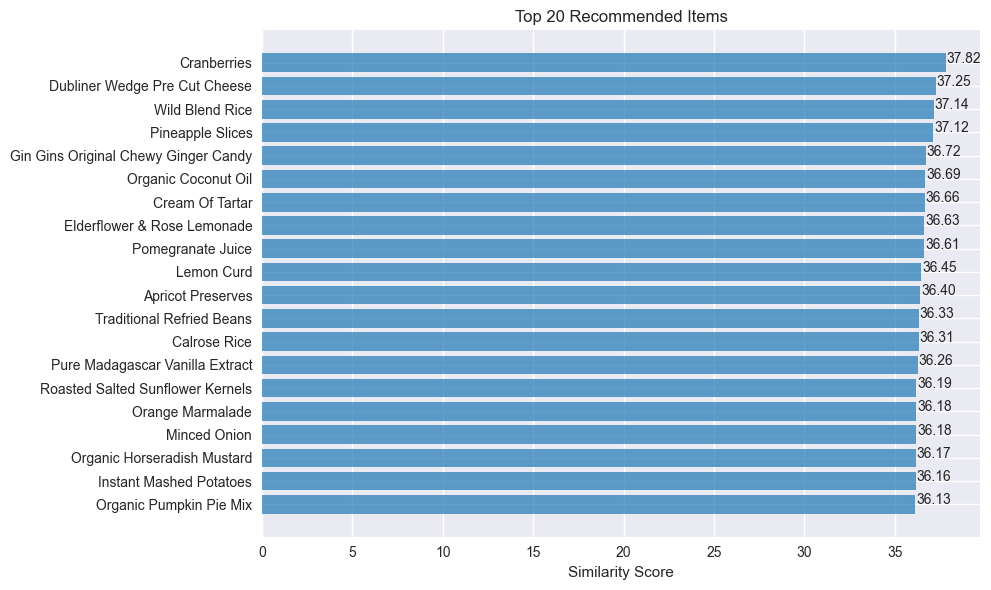

In [11]:
# Plot the Top-K Recommended Items
top_k_product_names = [pid_name_map[product_ids[i]] for i in top_k]
top_k_sim_scores = [item_cf_scores[i] for i in top_k]

plt.figure(figsize=(10, 6))
plt.barh(range(K), top_k_sim_scores, color='tab:blue', alpha=0.7)
plt.yticks(range(K), top_k_product_names)
plt.xlabel('Similarity Score')
plt.title(f'Top {K} Recommended Items')
plt.gca().invert_yaxis()

# Add labels
for i, score in enumerate(top_k_sim_scores):
    plt.text(score + 0.05, i, f'{score:.2f}')

plt.tight_layout()
plt.show()

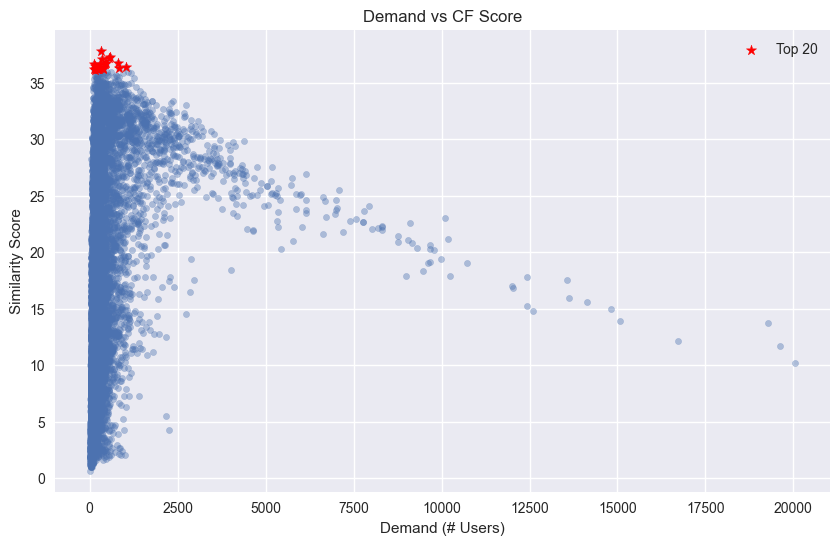

In [12]:
# We expect our cf approach to have picked items that are not very in demand, but have good similarity scores.
# This is because we mask out known interactions/demand, and are only predicting for unknown interactions.
item_demand = order_matrix_df.sum(axis=0)

plot_df = pd.DataFrame({
    'product_id': product_ids,
    'demand': [item_demand[pid] for pid in product_ids],
    'sim_score': item_cf_scores
})

plt.figure(figsize=(10, 6))
plt.scatter(plot_df['demand'], plot_df['sim_score'], alpha=0.4, s=20)

# Differentiate our top K
plt.scatter(
    [item_demand[product_ids[i]] for i in top_k],
    [item_cf_scores[i] for i in top_k],
    color='red', s=60, marker='*', label=f'Top {K}'
)

plt.xlabel('Demand (# Users)')
plt.ylabel('Similarity Score')
plt.title('Demand vs CF Score')
plt.legend()
plt.show()

In the scatter plot, our top-K recommendations all appear to have low demand with high similarity scores. This happens because of how our collaborative filtering works. When making predictions, we mask out the items that users have already purchased. Since popular/high-demand items are purchased by many users, they get masked out more often and their predicted scores drop. Alternatively, items that are not purchased very often (low demand) rarely get masked out, and if they are highly similar to popular items, their predicted similarity scores stay high. As a result, our top-K recommended items tend to be those that are rarely ordered but strongly similar to frequently purchased items, like 'hidden gems'.

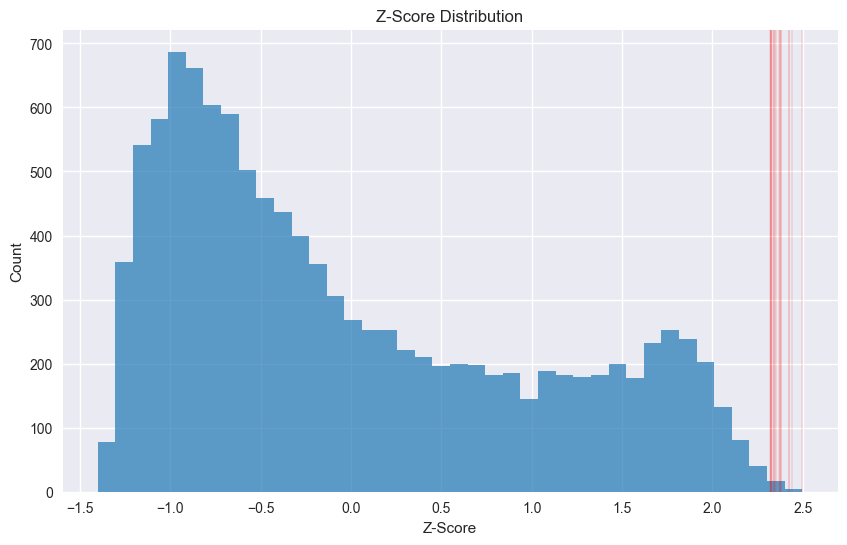

In [13]:
plt.figure(figsize=(10, 6))

plt.hist(item_z_scores, bins=40, color='tab:blue', alpha=0.7)

# z-scores for top-k items
top_k_z = [item_z_scores[i] for i in top_k]

# vertical lines for top-k items
for z in top_k_z:
    plt.axvline(z, color='red', alpha=0.1, linewidth=1.2)

plt.xlabel('Z-Score')
plt.ylabel('Count')
plt.title(f'Z-Score Distribution')
plt.show()

Based on this plot, we can see that the similarity scores of our top recommended items are about ~2.3-2.5 standard deviations above the average item's similarity score. 
This essentially means that the items we recommend are much more similar to frequently ordered items than the average product.